# U-net Model with fig-size 256*256 and the traning plots

Import libraries

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


## Preprocessing

### Resizing

read images and resize them: size = (256, 256, 3)

In [3]:
def read_images_from_folder_and_resizing(img_folder_path, mask_folder_path):
    images = []
    masks  = []
    img_paths  = []
    mask_paths = []
    for image_name in sorted(os.listdir(img_folder_path)):
        image_path = os.path.join(img_folder_path, image_name)
        img_paths.append(image_path)

    for mask_name in sorted(os.listdir(mask_folder_path)):
        mask_path = os.path.join(mask_folder_path, mask_name)
        mask_paths.append(mask_path)

    for img_path, mask_path in zip(img_paths, mask_paths):
        img  = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        desired_size = (256, 256)
        img  = cv2.resize(img, desired_size)
        mask = cv2.resize(mask, desired_size)

        images.append(img)
        masks.append(mask)
    return images, masks, img_paths, mask_paths



images_folder_path = 'Kvasir-SEG/images'
masks_folder_path  = 'Kvasir-SEG/masks'

images, masks, img_p, mask_p = read_images_from_folder_and_resizing(images_folder_path, masks_folder_path)
images = np.array(images)
masks  = np.array(masks)

### Normalizing

In [4]:
images = images / 255.
masks  = masks / 255.

print("Max pixel value (mask):", np.max(images))
print("Min pixel value (mask):", np.min(masks))

Max pixel value (mask): 1.0
Min pixel value (mask): 0.0


### Display an instance of a raw and a normalized images and their masks

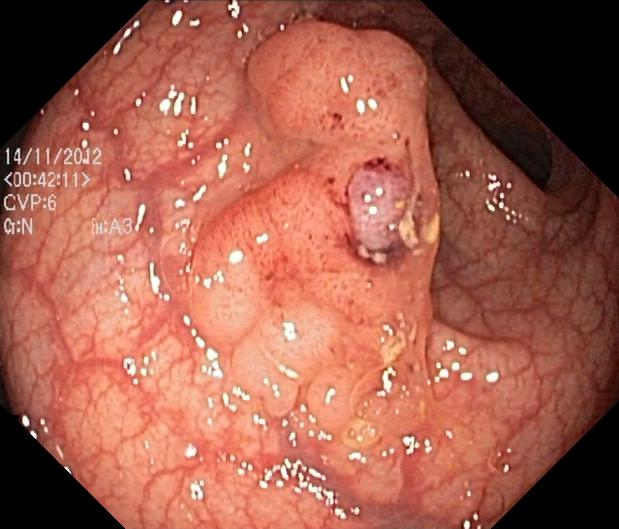

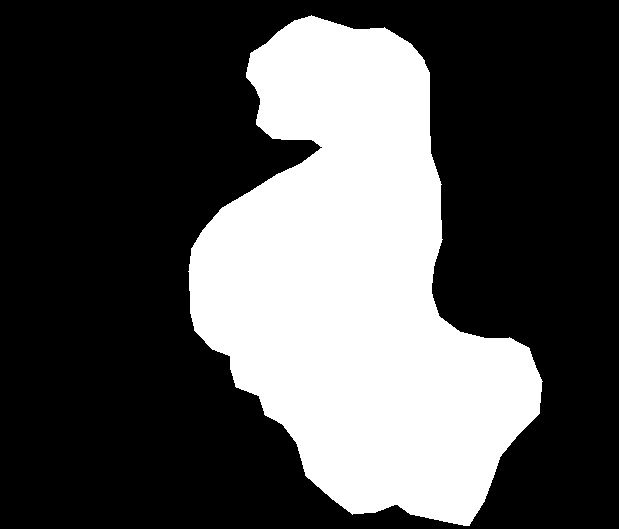

In [5]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

display(Image(filename=img_p[2]))

img = ImageOps.autocontrast(load_img(mask_p[2]))
display(img)

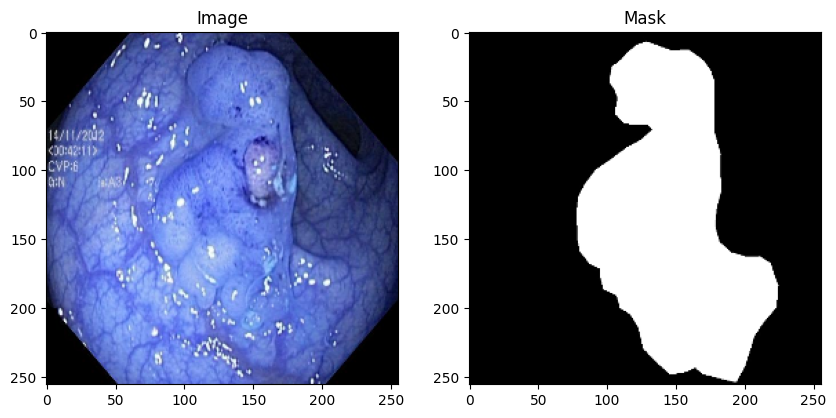

In [6]:
plt.figure(figsize=(10, 5))

# Display the first image
plt.subplot(1, 2, 1)
plt.imshow(images[2])
plt.title('Image')

# Display the first mask
plt.subplot(1, 2, 2)
plt.imshow(masks[2], cmap='gray')
plt.title('Mask')

plt.show()

### Spliting data into train, validation, and test.

In [8]:
def split_data(images, masks, split=0.1):
    total_size = len(images)
    test_size  = int(split * total_size)
    valid_size = int(split * total_size)

    X_train, X_valid = train_test_split(images, test_size=valid_size, random_state=42)
    y_train, y_valid = train_test_split(masks, test_size=valid_size, random_state=42)

    X_train, X_test = train_test_split(X_train, test_size=test_size, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [11]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_data(images, masks)

print(f"train set size: {len(X_train)}\nvalid set size: {len(X_valid)}\ntest set size:  {len(X_test)}")

train set size: 800
valid set size: 100
test set size:  100


## Construct U-net model

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def Unet(input_shape):

    inputs = Input(input_shape)

    layer1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    # layer5 = Dropout(0.5)(layer1)
    layer1 = Conv2D(16, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(layer1)

    layer2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    # layer5 = Dropout(0.5)(layer2)
    layer2 = Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(layer2)

    layer3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    # layer5 = Dropout(0.3)(layer3)
    layer3 = Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(layer3)

    layer4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    # layer5 = Dropout(0.3)(layer4)
    layer4 = Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(layer4)

    layer5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    layer5 = Dropout(0.3)(layer5)
    layer5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer5)

    upsam1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(layer5)
    upsam1 = Concatenate()([upsam1, layer4])
    layer6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam1)

    upsam2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(layer6)
    upsam2 = Concatenate()([upsam2, layer3])
    layer7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam2)

    upsam3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(layer7)
    upsam3 = Concatenate()([upsam3, layer2])
    layer8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam3)

    upsam4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(layer8)
    upsam4 = Concatenate()([upsam4, layer1])
    layer9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam4)

    layer10= Conv2D(1, (1, 1), activation='sigmoid')(layer9)

    model = Model(inputs=inputs, outputs=layer10)

    return model


In [20]:
model = Unet((256, 256, 3))
model.summary()

(None, 32, 32, 128) (None, 32, 32, 128)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │     448 │ input_layer_1[0][0]  │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │   2,320 │ conv2d_15[0][0]      │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │       0 │ conv2d_16[0][0]      │
│ (MaxPooling2D)      │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │   4,640 │ max_pooling2d_4[0][… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │   9,248 │ conv2d_17[0][0]      │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │       0 │ conv2d_18[0][0]      │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │  18,496 │ max_pooling2d_5[0][… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │  36,928 │ conv2d_19[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │       0 │ conv2d_20[0][0]      │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │  73,856 │ max_pooling2d_6[0][… │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │ 147,584 │ conv2d_21[0][0]      │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │       0 │ conv2d_22[0][0]      │
│ (MaxPooling2D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │ 295,168 │ max_pooling2d_7[0][… │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │       0 │ conv2d_23[0][0]      │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │ 590,080 │ dropout_1[0][0]      │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │ 131,200 │ conv2d_24[0][0]    

 Total params: 1,745,025 (6.66 MB)

 Trainable params: 1,745,025 (6.66 MB)

 Non-trainable params: 0 (0.00 B)

### Define functions for metrics Dice and IoU

In [21]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)


def iou_coef(y_true, y_pred, smooth=100):
    y_true = K.expand_dims(y_true, axis=-1)
    
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    
    return iou


## Training and Validation

### Compile the model

In [23]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef, dice_coef])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', iou_coef, dice_coef])

### Fit the model with epochs=25 and batch_size=32

In [24]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=32)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 166s 6s/step - accuracy: 0.7801 - dice_coef: 0.1660 - iou_coef: 0.0918 - loss: 0.7148 - val_accuracy: 0.8302 - val_dice_coef: 0.1967 - val_iou_coef: 0.1094 - val_loss: 0.4215
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.8396 - dice_coef: 0.2173 - iou_coef: 0.1222 - loss: 0.4049 - val_accuracy: 0.8303 - val_dice_coef: 0.2171 - val_iou_coef: 0.1222 - val_loss: 0.3771
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.8374 - dice_coef: 0.2409 - iou_coef: 0.1372 - loss: 0.3789 - val_accuracy: 0.8303 - val_dice_coef: 0.2538 - val_iou_coef: 0.1460 - val_loss: 0.3616
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 161s 6s/step - accuracy: 0.8355 - dice_coef: 0.2657 - iou_coef: 0.1537 - loss: 0.3603 - val_accuracy: 0.8303 - val_dice_coef: 0.2752 - val_iou_coef: 0.1603 - val_loss: 0.3651
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - accuracy: 0.8459 - dice_coef: 0.2696 - iou_coef: 0.1561 - loss: 0.3437 - val_accuracy: 0.8303 -

## Results and analysis

### Evaluate the model on test set

In [41]:
loss, accuracy, iou, dice = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}\nTest Accuracy: {accuracy}\niou: {iou}\ndice: {dice}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8924 - dice_coef: 0.5169 - iou_coef: 0.3493 - loss: 0.2513
Test Loss: 0.25515297055244446
Test Accuracy: 0.8901768326759338
iou: 0.5001018643379211
dice: 0.33459749817848206


### Plot training metrics

In [26]:
def plot_training(hist):

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

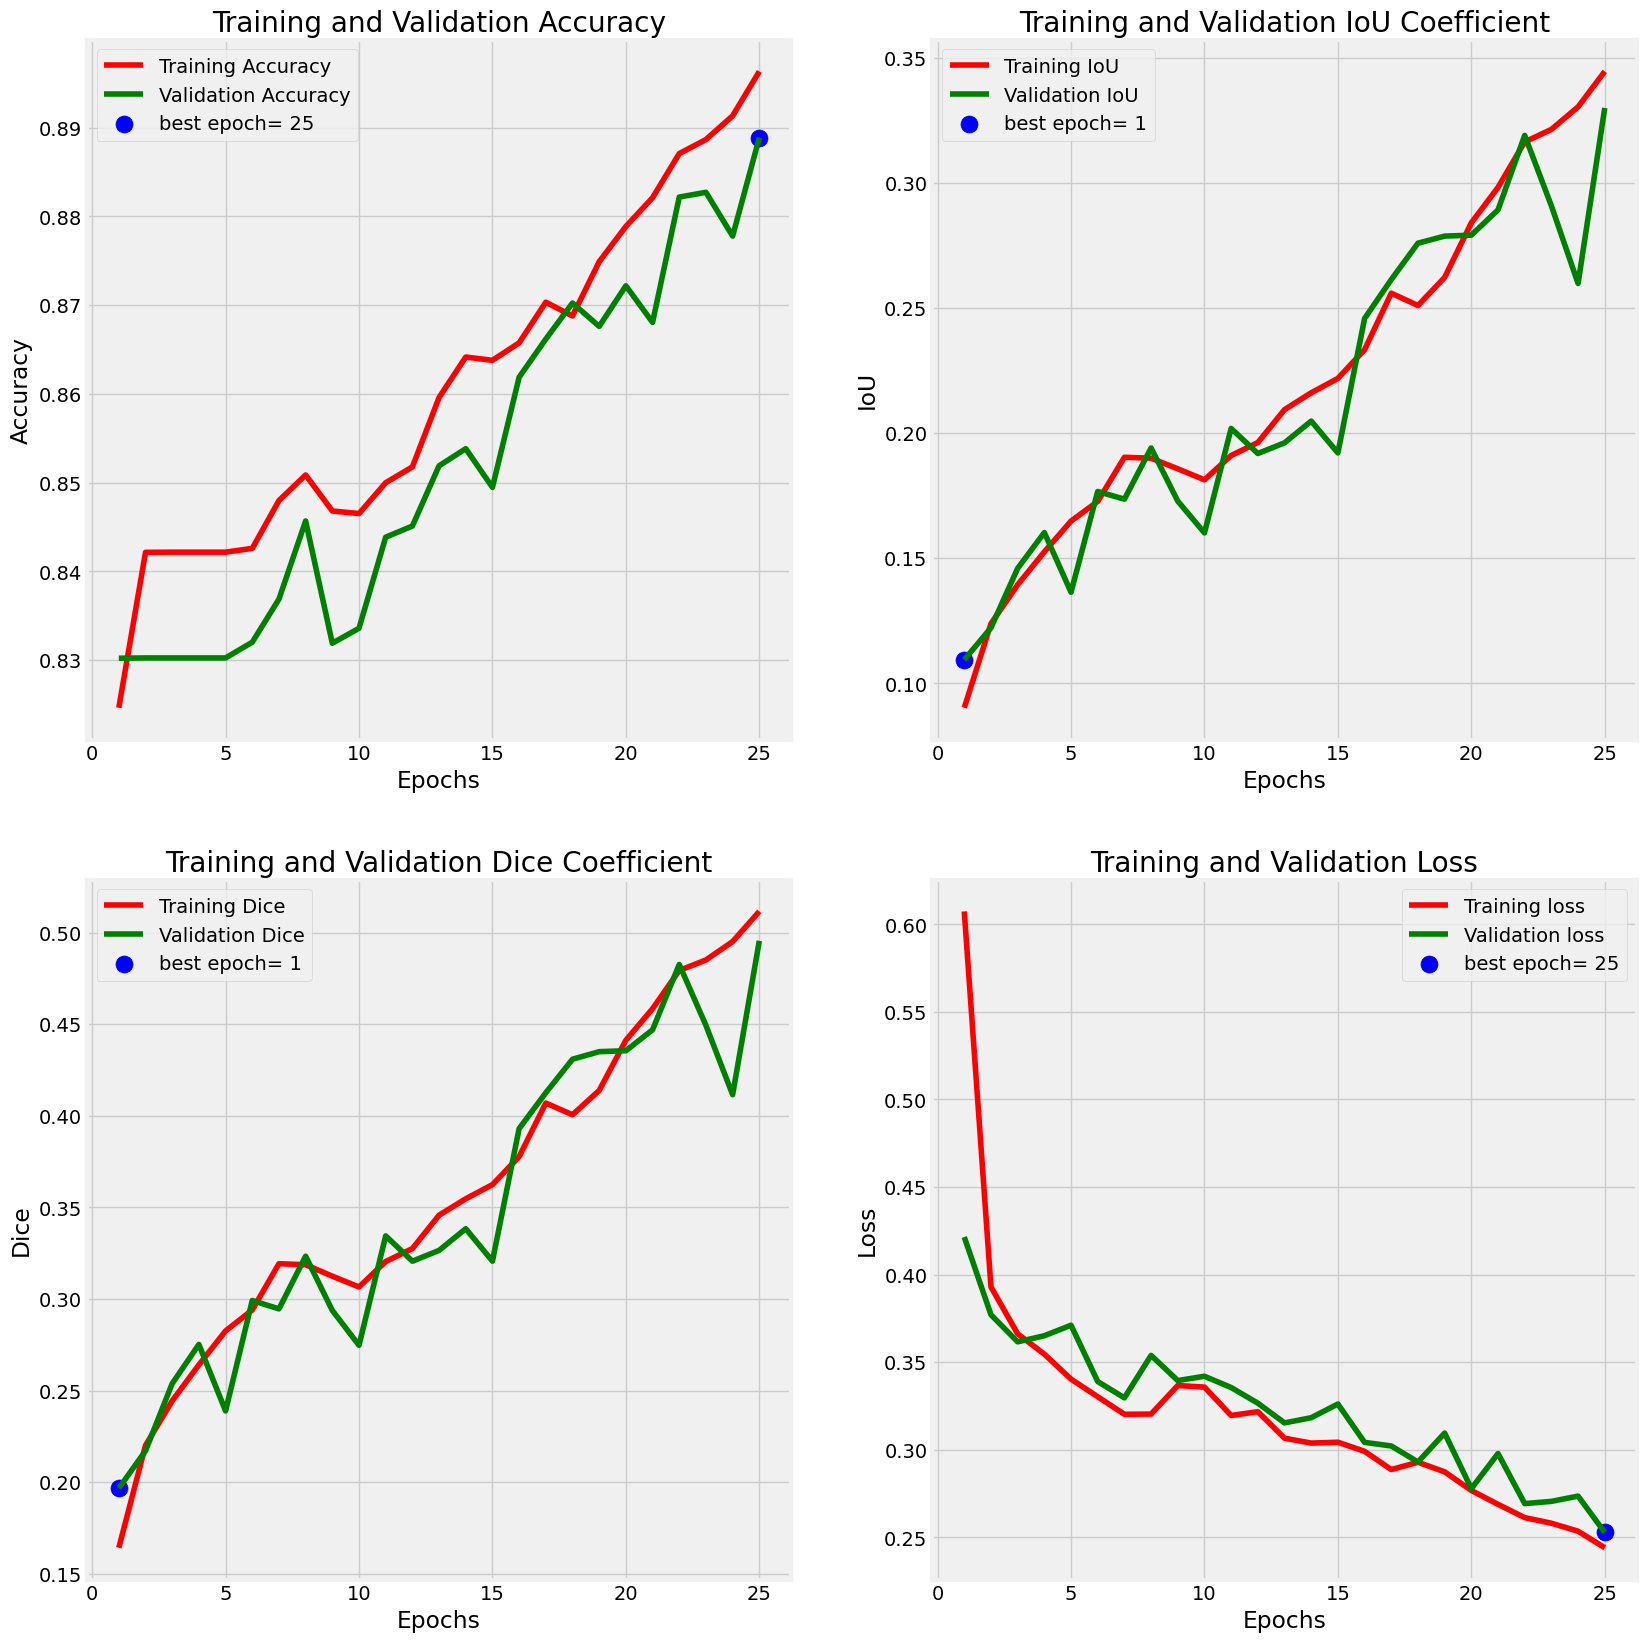

In [27]:
plot_training(history)

### Show the predictions

In [28]:
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


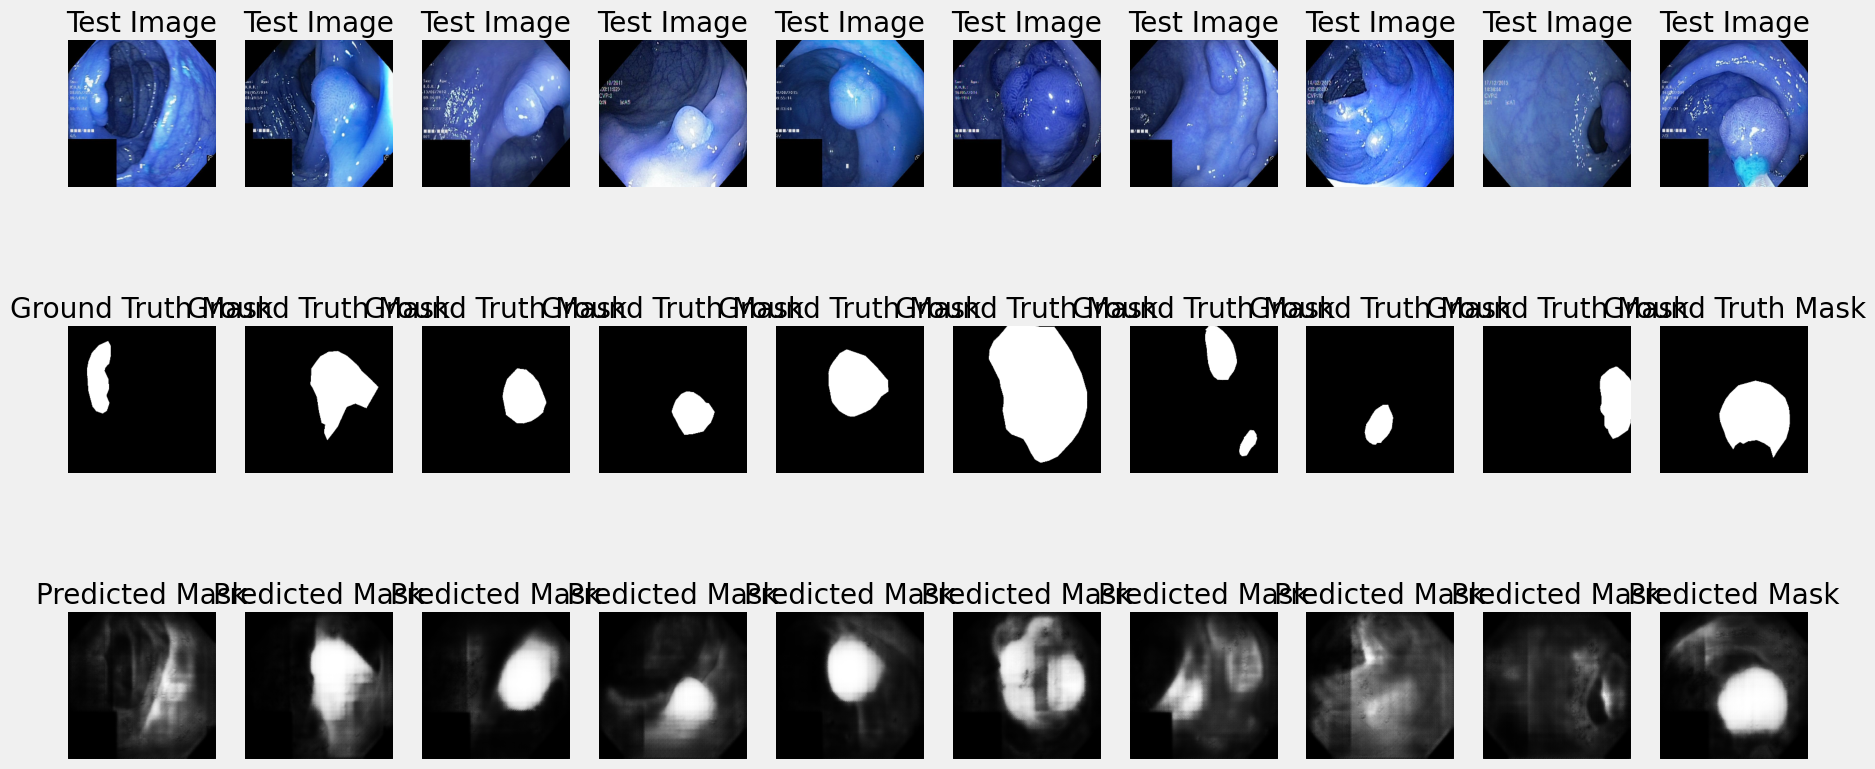

In [39]:
num_images = 10
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[i])
    plt.title('Test Image')
    plt.axis('off')
    
    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(y_test[i], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(predictions[i], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.show()